In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
df_paspor = pd.read_csv('17plus8.csv')

In [ ]:
df_paspor.head(10)

,Username,Name,Tweet Text,Tweet URL,Created at
0,jasutopia1,Jasutopia,17+8 Tuntutan RAKYAT\n\n#TuntutanRakyat #17plu...,https://twitter.com/jasutopia1/status/19636724...,2025-09-04 18:36:20+00:00
1,PETAJakarta,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik\nAnak muda dipak...,https://twitter.com/PETAJakarta/status/1966671...,2025-09-13 01:12:17+00:00
2,pengenjadiraftr,Pengen Jadi Rafathar,17+8\n#178TuntutanRakyat #17Plus8 #TuntutanRak...,https://twitter.com/pengenjadiraftr/status/196...,2025-09-07 11:40:11+00:00
3,RezaAnugrah_03,Ca,"Demo se cutesy ini, awas aja ada yang nuduh ma...",https://twitter.com/RezaAnugrah_03/status/1964...,2025-09-06 05:46:56+00:00
4,panggung2024,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,2025-09-03 09:05:37+00:00
5,Bercahayanew,bercahaya news,Prabowo menanggapi isu 17+8 dan menilai sejuml...,https://twitter.com/Bercahayanew/status/196531...,2025-09-09 07:10:14+00:00
6,DiskursusNet,Diskursus Network,"Ahli Fisika dan Matematika ITB, Alif Towew sus...",https://twitter.com/DiskursusNet/status/196895...,2025-09-19 08:33:45+00:00
7,Zibon_Update,ZIBON UPDATE,Presiden Prabowo akhirnya buka suara soal 17+8...,https://twitter.com/Zibon_Update/status/196502...,2025-09-08 11:51:51+00:00
8,DiskursusNet,Diskursus Network,SUPERVISI DAN KONTROL PIMPINAN DI POLRI LEMAH\...,https://twitter.com/DiskursusNet/status/197183...,2025-09-27 07:05:24+00:00
9,DiskursusNet,Diskursus Network,"Pakar Hukum Tata Negara, Feri Amsari nilai ada...",https://twitter.com/DiskursusNet/status/196934...,2025-09-20 10:00:01+00:00


In [ ]:
df_paspor['Username'] = df_paspor['Username'].astype(str)
df_paspor['Name'] = df_paspor['Name'].astype(str)
df_paspor['Tweet Text'] = df_paspor['Tweet Text'].astype(str)
df_paspor['Tweet URL'] = df_paspor['Tweet URL'].astype(str)
df_paspor['Created at'] = pd.to_datetime(df_paspor['Created at'])

In [ ]:
column_dtypes = df_paspor.dtypes
print(column_dtypes)

Username                   object
Name                       object
Tweet Text                 object
Tweet URL                  object
Created at    datetime64[ns, UTC]
dtype: object


In [ ]:
# Set the start and end date range
start_date = pd.to_datetime('2025-09-01').tz_localize('Asia/Jakarta')
end_date = pd.to_datetime('2025-10-15').tz_localize('Asia/Jakarta')

# Filter the DataFrame for data within the specified date range
df_ytd = df_paspor[(df_paspor['Created at'] >= start_date) & (df_paspor['Created at'] <= end_date)]

In [ ]:
num_records = len(df_ytd)
print("Number of records in df_ytd:", num_records)

Number of records in df_ytd: 39


In [ ]:
start_date = df_ytd['Created at'].min()
end_date = df_ytd['Created at'].max()

print("Start Date:", start_date)
print("End Date:", end_date)


Start Date: 2025-09-03 09:05:37+00:00
End Date: 2025-10-13 05:08:12+00:00


In [ ]:
df_textPreprocessing = df_ytd.copy()

In [ ]:
#Manual Labelling

# Initialize the label column
df_textPreprocessing['label'] = None

# Iterate over each row in the DataFrame
for index, row in df_textPreprocessing.iterrows():
    review = row['content']
    rating = row['score']

    # Manually assign a label based on the rating
    if rating in [1, 2]:
        label = 'Negative'
    elif rating in [4, 5]:
        label = 'Positive'
    else:
        label = 'Neutral'

    # Update the 'label' column for the current row
    df_textPreprocessing.at[index, 'label'] = label


KeyError: 'content'

In [ ]:
# Delete rows with "Neutral" label
df_textPreprocessing = df_textPreprocessing[df_textPreprocessing['label'] != 'Neutral']

# Remove neutral ratings
df_textPreprocessing = df_textPreprocessing[~df_textPreprocessing['score'].isin([3])]


In [ ]:
num_records = len(df_textPreprocessing)
print("Number of records in df_textPreprocessing:", num_records)

Number of records in df_textPreprocessing: 39


In [ ]:
columns_to_drop = ['Username', 'Created at']
df_textPreprocessing = df_textPreprocessing.drop(columns=columns_to_drop)

In [ ]:
df_textPreprocessing.tail(10)

,Name,Tweet Text,Tweet URL,label
29,Qolbi Fauzie,"Jumat\nMBG: Seharusnya nutrisi gratis, tapi ja...",https://twitter.com/bobby_fauzie/status/196905...,None
30,Project Multatuli,Apa kabar rencana Reformasi Polri? \n\nTernyat...,https://twitter.com/projectm_org/status/197262...,None
31,Ekspedisi Indonesia Baru,"Ahli Hukum Tata Negara, @BivitriS , di depan G...",https://twitter.com/idbaruid/status/1976949925...,None
32,ses #1312,#ResetIndonesia https://t.co/d1fifzFax4,https://twitter.com/monroevIIe/status/19670973...,None
33,Amnesty International Malaysia,More than 2000 people in Indonesia have been a...,https://twitter.com/AmnestyMy/status/196853337...,None
34,Ekspedisi Indonesia Baru,#ResetIndonesia is everywhere. https://t.co/8E...,https://twitter.com/idbaruid/status/1976908660...,None
35,Komunitas Bambu,Kalau ingin rebut kemerdekaan lagi dan mewujud...,https://twitter.com/KomunitasBambu/status/1966...,None
36,Dandhy Laksono,#ResetIndonesia https://t.co/hrkfXXNDcm,https://twitter.com/Dandhy_Laksono/status/1971...,None
37,Dex Glennıza,"Kalau cuma mau lolos ke Piala Dunia, kita gak ...",https://twitter.com/dexglenniza/status/1976688...,None
38,Ekspedisi Indonesia Baru,#ResetIndonesia https://t.co/uwRGDT7Udb,https://twitter.com/idbaruid/status/1977358996...,None


In [ ]:
#remove punctuations
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[^\w]|_',' ')

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3994149357.py:2: SyntaxWarning: invalid escape sequence '\w'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[^\w]|_',' ')


In [ ]:
#remove digit or numbers
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\d+", " ")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1446038192.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\d+", " ")


In [ ]:
#remove word with digit
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\S*\d\S*", " ")

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-558749996.py:2: SyntaxWarning: invalid escape sequence '\S'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace("\S*\d\S*", " ")


In [ ]:
#Remove additional white spaces
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[\s]+', ' ')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1556028408.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].str.replace('[\s]+', ' ')


In [ ]:
# Define the normalization mapping based on KBBI
normalization_mapping = {
    'di': 'di',
    'ini': 'ini',
    'dan': 'dan',
    'ok': 'bagus',
    'nya': 'nya',
    'aku': 'aku',
    'Ok': 'bagus',
    'ada': 'ada',
    'tik': 'tik',
    'Aku': 'aku',
    'yg': 'yang',
    'gak': 'tidak',
    'ga': 'tidak',
    'ku': 'kamu',
    'the': 'the',
    'ya': 'ya',
    '5': 'lima',
    'aja': 'saja',
    'I': 'saya',
    'apk': 'aplikasi',
    '👍': 'bagus',
    'ke': 'ke',
    'mau': 'mau',
    'you': 'kamu',
    'kok': 'kok',
    'gk': 'tidak',
    'fyp': 'fyp',
    'sih': 'sih',
    'apa': 'apa',
    'Apk': 'aplikasi',
    'd': 'di',
    'app': 'aplikasi',
    'itu': 'itu',
    'ok': 'bagus',
    'lah': 'lah',
    'bgt': 'banget',
    'to': 'ke',
    '3': 'tiga',
    'is': 'adalah',
    'ko': 'kamu',
    'Ini': 'ini',
    'nia': 'nia',
    'and': 'dan',
    '2': 'dua',
    'hp': 'handphone',
    'kan': 'kan',
    'deh': 'deh',
    'Top': 'bagus',
    'gua': 'saya',
    'Oke': 'bagus',
    'my': 'saya',
    'i': 'saya',
    'ny': 'nya',
    'dgn': 'dengan',
    'Top.': 'bagus',
    'dagus': 'bagus',
    'bs': 'bisa',
    'senagsekali': 'senang sekali',
    'ferbaiki': 'perbaiki',
    'waifi': 'wifi',
    'The best': 'terbaik',
    'Mantab': 'mantap',
    'bgus': 'bagus',
    'Ko': 'kamu',
    'bgt': 'banget',
    'knp': 'kenapa',
    'jgn': 'jangan',
    'gtw': 'enggak tahu',
    'bsk': 'besok',
    'lgsg': 'langsung',
    'y': 'ya',
    'jg': 'juga',
    'tp': 'tapi',
    'trs': 'terus',
    'jd': 'jadi',
    'pdhl': 'padahal',
    'blm': 'belum',
    'dpt': 'dapat',
    'gk': 'gak',
    'bb': 'badan',
    'mgkn': 'mungkin',
    'sm': 'sama',
    'bngt': 'banget',
    'sgt': 'sangat',
    'gaul': 'keren',
    'cuy': 'bro',
    'mantap': 'bagus',
    'ngab': 'bro',
    'asem': 'asli semangat',
    'pake': 'pakai',
    'mabar': 'main bareng',
    'lahir batin': 'sepenuh hati',
    'tolol': 'bodoh',
    'baper': 'bawa perasaan',
    'wkwk': 'haha',
    'abis': 'habis',
    'wibu': 'penggemar budaya Jepang',
    'asyikkk': 'asyik',
    'baguus': 'bagus',
    'selaluih': 'selalu',
    'mmantap': 'mantap',
    'stabilo': 'stabil',
    'terbaikk': 'terbaik',
    'percumaa': 'percuma',
    'mahall': 'mahal',
    'manstap': 'mantap',
    'terbainya': 'terbaiknya',
    'malahh': 'malah',
    'tulusin': 'tuluskan',
    'gadaa': 'gak ada',
    'tok': 'tiktok',
    'menyedot': 'menghisap',
    'good': 'bagus',
    'bagu': 'bagus'

}

# Function to perform manual normalization
def normalize_text(text):
    normalized_text = []
    words = text.split()
    for word in words:
        if word in normalization_mapping:
            normalized_word = normalization_mapping[word]
            normalized_text.append(normalized_word)
        else:
            normalized_text.append(word)
    normalized_text = ' '.join(normalized_text)
    return normalized_text

# Apply the text normalization function to the 'content' column
df_textPreprocessing['Tweet Text'] = df_textPreprocessing['Tweet Text'].apply(normalize_text)

In [ ]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,label
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,None
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,None
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,None
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,None
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,None


In [ ]:
def case_folding(review):
    # Convert the review to lowercase
    folded_review = review.lower()
    return folded_review

df_textPreprocessing['folded_content'] = df_textPreprocessing['Tweet Text'].apply(case_folding)

In [ ]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,label,folded_content
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,None,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,None,bahaya latent (fakta) politik anak muda dipaks...
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,None,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,None,"demo se cutesy ini, awas saja ada yang nuduh m..."
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,None,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ..."


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Additional stop words
more_stopword = ['sy','nya','n','bgt','banget','d','bu','pak','dengan','dgn','kemaren','kmrin','dear','yth','ass','gak','ny','cari','dibantu','mohon','saja','aja','malam','selamat','sore','siang','pagi','asalamualaikum','wb','wr','assalamualaikum','sya','yg', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berkenaan', 'berlainan', 'berlalu', 'berlangsung', 'berlebihan', 'bermacam', 'bermacam-macam', 'bermaksud', 'bermula', 'bersama', 'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya', 'berturut', 'berturut-turut', 'bertutur', 'berujar', 'berupa', 'besar', 'betul', 'betulkah', 'biasa', 'biasanya', 'bila', 'bilakah', 'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah', 'buat', 'bukan', 'bukankah', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya', 'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 'dapat', 'dari', 'daripada', 'datang', 'dekat', 'demi', 'demikian', 'demikianlah', 'dengan', 'depan', 'di', 'dia', 'diakhiri', 'diakhirinya', 'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 'diberikannya', 'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 'digunakan', 'diibaratkan', 'diibaratkannya', 'diingat', 'diingatkan', 'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan', 'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 'dikira', 'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 'dimaksudkannya', 'dimaksudnya', 'diminta', 'dimintai', 'dimisalkan', 'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan', 'dini', 'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 'diperkirakan', 'diperlihatkan', 'diperlukan', 'diperlukannya', 'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya', 'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 'disinilah', 'ditambahkan', 'ditandaskan', 'ditanya', 'ditanyai', 'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk', 'ditunjuki', 'ditunjukkan', 'ditunjukkannya', 'ditunjuknya', 'dituturkan', 'dituturkannya', 'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 'dua', 'dulu', 'empat', 'enggak', 'enggaknya', 'entah', 'entahlah', 'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 'harus', 'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 'hingga', 'ia', 'ialah', 'ibarat', 'ibaratkan', 'ibaratnya', 'ibu', 'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan', 'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jadilah', 'jadinya', 'jangan', 'jangankan', 'janganlah', 'jauh', 'jawab', 'jawaban', 'jawabnya', 'jelas', 'jelaskan', 'jelaslah', 'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 'kala', 'kalau', 'kalaulah', 'kalaupun', 'kalian', 'kami', 'kamilah', 'kamu', 'kamulah', 'kan', 'kapan', 'kapankah', 'kapanpun', 'karena', 'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah', 'katanya', 'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya', 'keinginan', 'kelamaan', 'kelihatan', 'kelihatannya', 'kelima', 'keluar', 'kembali', 'kemudian', 'kemungkinan', 'kemungkinannya', 'kenapa', 'kepada', 'kepadanya', 'kesampaian', 'keseluruhan', 'keseluruhannya', 'keterlaluan', 'ketika', 'khususnya', 'kini', 'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 'kurang', 'lagi', 'lagian', 'lah', 'lain', 'lainnya', 'lalu', 'lama', 'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat', 'lima', 'luar', 'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 'mampukah', 'mana', 'manakala', 'manalagi', 'masa', 'masalah', 'masalahnya', 'masih', 'masihkah', 'masing', 'masing-masing', 'mau', 'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya', 'memang', 'memastikan', 'memberi', 'memberikan', 'membuat', 'memerlukan', 'memihak', 'meminta', 'memintakan', 'memisalkan', 'memperbuat', 'mempergunakan', 'memperkirakan', 'memperlihatkan', 'mempersiapkan', 'mempersoalkan', 'mempertanyakan', 'mempunyai', 'memulai', 'memungkinkan', 'menaiki', 'menambahkan', 'menandaskan', 'menanti', 'menanti-nanti', 'menantikan', 'menanya', 'menanyai', 'menanyakan', 'mendapat', 'mendapatkan', 'mendatang', 'mendatangi', 'mendatangkan', 'menegaskan', 'mengakhiri', 'mengapa', 'mengatakan', 'mengatakannya', 'mengenai', 'mengerjakan', 'mengetahui', 'menggunakan', 'menghendaki', 'mengibaratkan', 'mengibaratkannya', 'mengingat', 'mengingatkan', 'menginginkan', 'mengira', 'mengucapkan', 'mengucapkannya', 'mengungkapkan', 'menjadi', 'menjawab', 'menjelaskan', 'menuju', 'menunjuk', 'menunjuki', 'menunjukkan', 'menunjuknya', 'menurut', 'menuturkan', 'menyampaikan', 'menyangkut', 'menyatakan', 'menyebutkan', 'menyeluruh', 'menyiapkan', 'merasa', 'mereka', 'merekalah', 'merupakan', 'meski', 'meskipun', 'meyakini', 'meyakinkan', 'minta', 'mirip', 'misal', 'misalkan', 'misalnya', 'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 'mungkinkah', 'nah', 'naik', 'namun', 'nanti', 'nantinya', 'nyaris', 'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya', 'pak', 'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 'pentingnya', 'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 'pernah', 'persoalan', 'pertama', 'pertama-tama', 'pertanyaan', 'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun', 'punya', 'rasa', 'rasanya', 'rata', 'rupanya', 'saat', 'saatnya', 'saja', 'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 'sampai-sampai', 'sampaikan', 'sana', 'sangat', 'sangatlah', 'satu', 'saya', 'sayalah', 'se', 'sebab', 'sebabnya', 'sebagai', 'sebagaimana', 'sebagainya', 'sebagian', 'sebaik', 'sebaik-baiknya', 'sebaiknya', 'sebaliknya', 'sebanyak', 'sebegini', 'sebegitu', 'sebelum', 'sebelumnya', 'sebenarnya', 'seberapa', 'sebesar', 'sebetulnya', 'sebisanya', 'sebuah', 'sebut', 'sebutlah', 'sebutnya', 'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit', 'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 'sehingga', 'seingat', 'sejak', 'sejauh', 'sejenak', 'sejumlah', 'sekadar', 'sekadarnya', 'sekali', 'sekali-kali', 'sekalian', 'sekaligus', 'sekalipun', 'sekarang', 'sekarang', 'sekecil', 'seketika', 'sekiranya', 'sekitar', 'sekitarnya', 'sekurang-kurangnya', 'sekurangnya', 'sela', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya', 'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 'semakin', 'semampu', 'semampunya', 'semasa', 'semasih', 'semata', 'semata-mata', 'semaunya', 'sementara', 'semisal', 'semisalnya', 'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian', 'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 'sepantasnya', 'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 'sepihak', 'sering', 'seringnya', 'serta', 'serupa', 'sesaat', 'sesama', 'sesampai', 'sesegera', 'sesekali', 'seseorang', 'sesuatu', 'sesuatunya', 'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap', 'setiba', 'setibanya', 'setidak-tidaknya', 'setidaknya', 'setinggi', 'seusai', 'sewaktu', 'siap', 'siapa', 'siapakah', 'siapapun', 'sini', 'sinilah', 'soal', 'soalnya', 'suatu', 'sudah', 'sudahkah', 'sudahlah', 'supaya', 'tadi', 'tadinya', 'tahu', 'tahun', 'tak', 'tambah', 'tambahnya', 'tampak', 'tampaknya', 'tandas', 'tandasnya', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi', 'tegas', 'tegasnya', 'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 'tentunya', 'tepat', 'terakhir', 'terasa', 'terbanyak', 'terdahulu', 'terdapat', 'terdiri', 'terhadap', 'terhadapnya', 'teringat', 'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira', 'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersampaikan', 'tersebut', 'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama', 'tetap', 'tetapi', 'tiap', 'tiba', 'tiba-tiba', 'tidak', 'tidakkah', 'tidaklah', 'tiga', 'tinggi', 'toh', 'tunjuk', 'turut', 'tutur', 'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umum', 'umumnya', 'ungkap', 'ungkapnya', 'untuk', 'usah', 'usai', 'waduh', 'wah', 'wahai', 'waktu', 'waktunya', 'walau', 'walaupun', 'wong', 'yaitu', 'yakin', 'yakni', 'yang']
# Create a dictionary with the default stop words and your additional stop words
stop_words = set(stopwords.words('indonesian')) | set(more_stopword)

def remove_stop_words(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a string
    return ' '.join(filtered_tokens)

# Apply the function to your DataFrame
df_textPreprocessing['content_without_stopwords'] = df_textPreprocessing['folded_content'].apply(remove_stop_words)

In [ ]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,label,folded_content,content_without_stopwords
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,None,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...,17+8 tuntutan rakyat # tuntutanrakyat # 17plus...
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,None,bahaya latent (fakta) politik anak muda dipaks...,bahaya latent ( fakta ) politik anak muda dipa...
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,None,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...,17+8 # 178tuntutanrakyat # 17plus8 # tuntutanr...
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,None,"demo se cutesy ini, awas saja ada yang nuduh m...","demo cutesy , awas nuduh makar yeee🤏🏻 . # acab..."
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,None,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ...","“ 17+8 tuntutan rakyat ” : tarik tni , usut ko..."


In [ ]:
def tokenize_text(review):
    # Tokenize the review into individual words
    tokens = nltk.word_tokenize(review)
    return tokens

df_textPreprocessing['tokens'] = df_textPreprocessing['content_without_stopwords'].apply(tokenize_text)

In [ ]:
df_textPreprocessing.head(5)

,Name,Tweet Text,Tweet URL,label,folded_content,content_without_stopwords,tokens
0,Jasutopia,17+8 Tuntutan RAKYAT #TuntutanRakyat #17plus8 ...,https://twitter.com/jasutopia1/status/19636724...,None,17+8 tuntutan rakyat #tuntutanrakyat #17plus8 ...,17+8 tuntutan rakyat # tuntutanrakyat # 17plus...,"[17+8, tuntutan, rakyat, #, tuntutanrakyat, #,..."
1,PETA Jakarta 🇰🇼,Bahaya Latent (Fakta) Politik Anak muda dipaks...,https://twitter.com/PETAJakarta/status/1966671...,None,bahaya latent (fakta) politik anak muda dipaks...,bahaya latent ( fakta ) politik anak muda dipa...,"[bahaya, latent, (, fakta, ), politik, anak, m..."
2,Pengen Jadi Rafathar,17+8 #178TuntutanRakyat #17Plus8 #TuntutanRaky...,https://twitter.com/pengenjadiraftr/status/196...,None,17+8 #178tuntutanrakyat #17plus8 #tuntutanraky...,17+8 # 178tuntutanrakyat # 17plus8 # tuntutanr...,"[17+8, #, 178tuntutanrakyat, #, 17plus8, #, tu..."
3,Ca,"Demo se cutesy ini, awas saja ada yang nuduh m...",https://twitter.com/RezaAnugrah_03/status/1964...,None,"demo se cutesy ini, awas saja ada yang nuduh m...","demo cutesy , awas nuduh makar yeee🤏🏻 . # acab...","[demo, cutesy, ,, awas, nuduh, makar, yeee🤏🏻, ..."
4,Panggung Politik,"“17+8 Tuntutan Rakyat” jelas: tarik TNI, usut ...",https://twitter.com/panggung2024/status/196316...,None,"“17+8 tuntutan rakyat” jelas: tarik tni, usut ...","“ 17+8 tuntutan rakyat ” : tarik tni , usut ko...","[“, 17+8, tuntutan, rakyat, ”, :, tarik, tni, ..."


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stemmer = StemmerFactory().create_stemmer()

def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_sentence = ' '.join(stemmed_tokens)  # Join tokens with whitespace separator
    return stemmed_sentence

df_textPreprocessing['stemmed_sentence'] = df_textPreprocessing['tokens'].apply(stem_tokens)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
df_textPreprocessing.head(5)

In [ ]:
!pip install transformers==3.5.1
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

  Using cached transformers-3.5.1-py3-none-any.whl.metadata (32 kB)
  Using cached tokenizers-0.9.3.tar.gz (172 kB)
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [ ]:
# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class index
    predictions = torch.argmax(outputs.logits, dim=1)

    # Map the index to the corresponding label
    sentiment_labels = ['positive', 'neutral', 'negative']
    return sentiment_labels[predictions.item()]

# Apply the function to your dataframe
# [cite_start]We'll use the 'stemmed_sentence' column as it's the most processed one [cite: 1, 2, 9, 10, 18, 32, 33, 38, 42, 51, 62]
df['sentiment'] = df['stemmed_sentence'].apply(predict_sentiment)

# Display the results
print(df[['stemmed_sentence', 'sentiment']].head(10))

# THIS IS THE TRAINING STUFF IDK IF WE NEED IT

In [ ]:
df_featuresExtraction = df_textPreprocessing.copy()

In [ ]:
X = df_featuresExtraction['stemmed_sentence'] #features
y = df_featuresExtraction['label'] #label

In [ ]:
from sklearn.model_selection import train_test_split
#80:20 Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer with desired n-gram range
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit the vectorizer on the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

Sentimen Analysis Clasification

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_accuracy = nb_model.score(X_test_tfidf, y_test)

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
from sklearn.svm import SVC
#Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_accuracy = svm_model.score(X_test_tfidf, y_test)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_accuracy = rf_model.score(X_test_tfidf, y_test)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
# Naive Bayes
nb_accuracy = nb_model.score(X_test_tfidf, y_test)
print("Naive Bayes Accuracy:", nb_accuracy)

# Support Vector Machine (SVM)
svm_accuracy = svm_model.score(X_test_tfidf, y_test)
print("SVM Accuracy:", svm_accuracy)

# Random Forest
rf_accuracy = rf_model.score(X_test_tfidf, y_test)
print("Random Forest Accuracy:", rf_accuracy)

AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

In [ ]:
total_records = len(df_featuresExtraction)
train_ratio = 0.8

num_train_records = int(total_records * train_ratio)
num_test_records = total_records - num_train_records

print("Number of train data records:", num_train_records)
print("Number of test data records:", num_test_records)

Number of train data records: 31
Number of test data records: 8


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset using the Naive Bayes model
nb_y_pred = nb_model.predict(X_test_tfidf)

# Calculate the confusion matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

In [ ]:
# Naive Bayes
nb_predicted = nb_model.predict(X_test_tfidf)
nb_report = classification_report(y_test, nb_predicted, zero_division=0)

print("Naive Bayes Classification Report:")
print(nb_report)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      1.00      0.94      2094
    Positive       0.98      0.25      0.40       332

    accuracy                           0.90      2426
   macro avg       0.94      0.63      0.67      2426
weighted avg       0.91      0.90      0.87      2426



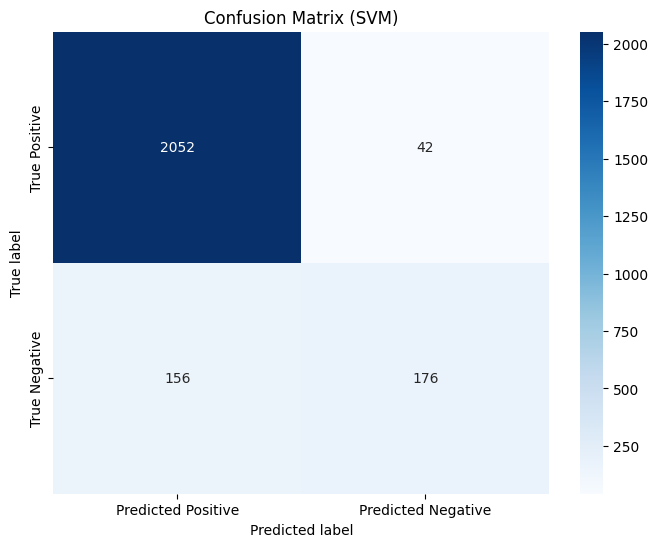

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
svm_predicted = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, svm_predicted)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

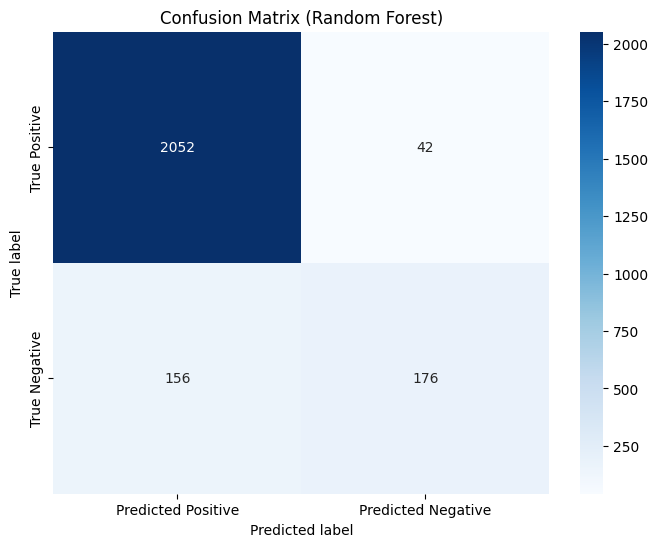

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
rf_predicted = rf_model.predict(X_test_tfidf)
rf = confusion_matrix(y_test, rf_predicted)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

rf_predicted = rf_model.predict(X_test_tfidf)
rf_report = classification_report(y_test, rf_predicted, zero_division=0)

print("Random Forest Classification Report:")
print(rf_report)
print(f"Number of trees in the Random Forest: {rf_model.n_estimators}")


Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.95      2094
    Positive       0.77      0.60      0.67       332

    accuracy                           0.92      2426
   macro avg       0.85      0.79      0.81      2426
weighted avg       0.92      0.92      0.92      2426

Number of trees in the Random Forest: 100


In [ ]:
# Calculate the classification report for each model
nb_report = classification_report(y_test, nb_predicted, zero_division=0, output_dict=True)
svm_report = classification_report(y_test, svm_predicted, zero_division=0, output_dict=True)
rf_report = classification_report(y_test, rf_predicted, zero_division=0, output_dict=True)

# Extract the evaluation metrics
nb_precision = nb_report['weighted avg']['precision']
nb_recall = nb_report['weighted avg']['recall']
nb_f1_score = nb_report['weighted avg']['f1-score']
nb_accuracy = nb_report['accuracy']

svm_precision = svm_report['weighted avg']['precision']
svm_recall = svm_report['weighted avg']['recall']
svm_f1_score = svm_report['weighted avg']['f1-score']
svm_accuracy = svm_report['accuracy']

rf_precision = rf_report['weighted avg']['precision']
rf_recall = rf_report['weighted avg']['recall']
rf_f1_score = rf_report['weighted avg']['f1-score']
rf_accuracy = rf_report['accuracy']

# Print the comparison table
print("Comparison of Classification Model's Result")
print("Model\t\tPrecision\tRecall\t\tF-1 Score\tAccuracy")
print("Naive Bayes\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(nb_precision, nb_recall, nb_f1_score, nb_accuracy))
print("Support Vector Machine\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(svm_precision, svm_recall, svm_f1_score, svm_accuracy))
print("Random Forest\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(rf_precision, rf_recall, rf_f1_score, rf_accuracy))


Comparison of Classification Model's Result
Model		Precision	Recall		F-1 Score	Accuracy
Naive Bayes	0.905		0.897		0.869		0.897
Support Vector Machine	0.913		0.918		0.911		0.918
Random Forest	0.915		0.920		0.916		0.920


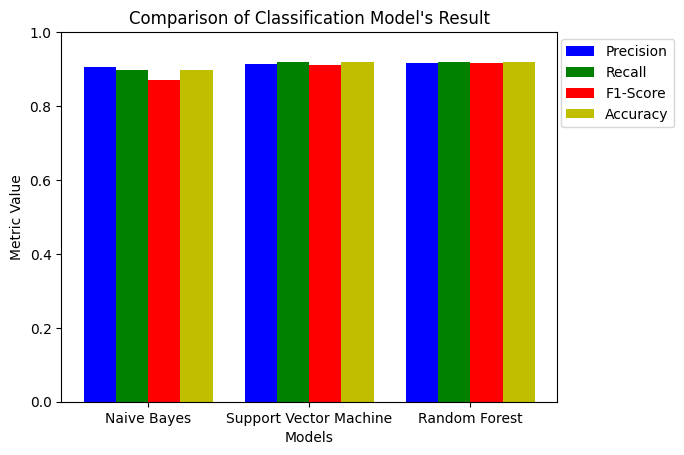

In [ ]:
import matplotlib.pyplot as plt

# Define the models and their corresponding metric values
models = ['Naive Bayes', 'Support Vector Machine', 'Random Forest']
precision = [nb_precision, svm_precision, rf_precision]
recall = [nb_recall, svm_recall, rf_recall]
f1_score = [nb_f1_score, svm_f1_score, rf_f1_score]
accuracy = [nb_accuracy, svm_accuracy, rf_accuracy]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar chart
plt.bar(r1, precision, color='b', width=bar_width, label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, label='F1-Score')
plt.bar(r4, accuracy, color='y', width=bar_width, label='Accuracy')

# Add x-axis labels and title
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of Classification Model\'s Result')

# Add y-axis range and tick labels
plt.ylim(0, 1)
plt.xticks([r + bar_width * 1.5 for r in range(len(models))], models)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

# Display the chart
plt.show()


In [ ]:
from collections import Counter

# Filter the DataFrame for positive label records
positive_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Tokenize the string into individual words
positive_tokens = nltk.word_tokenize(positive_reviews)

# Count the frequency of each word
word_freq = Counter(positive_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Number of top words to retrieve
top_n = 10

# Retrieve the top N words with the highest frequencies
top_words = sorted_word_freq[:top_n]

# Print the top words and their frequencies
for word, freq in top_words:
    print(word, freq)


bagus 371
aplikasi 337
mudah 234
paspor 221
bantu 213
bayar 128
daftar 119
imigrasi 109
mantap 97
good 70


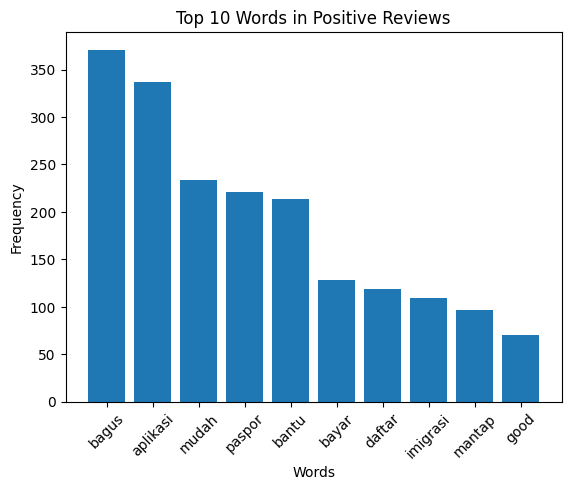

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the top N words and their frequencies
top_words = sorted_word_freq[:top_n]

# Extract the words and frequencies into separate lists
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar plot
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Positive Reviews'.format(top_n))

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()


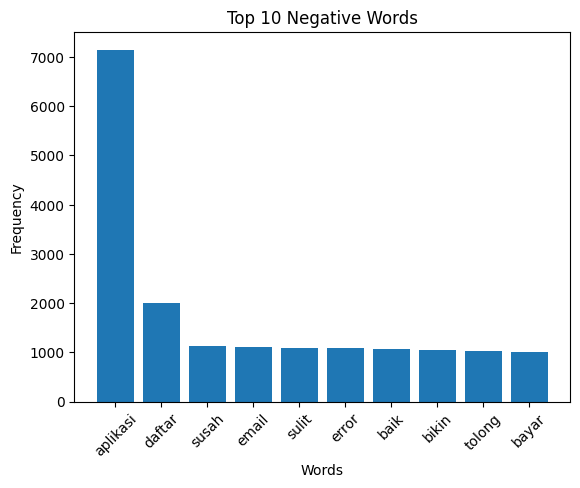

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Filter the DataFrame for negative label records
negative_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Tokenize the string into individual words
negative_tokens = nltk.word_tokenize(negative_reviews)

# Count the frequency of each word
word_freq = Counter(negative_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Retrieve the top 10 words with the highest frequencies
top_words = sorted_word_freq[:10]

# Extract the words and frequencies for plotting
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar chart
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Negative Words')
plt.xticks(rotation=45)
plt.show()


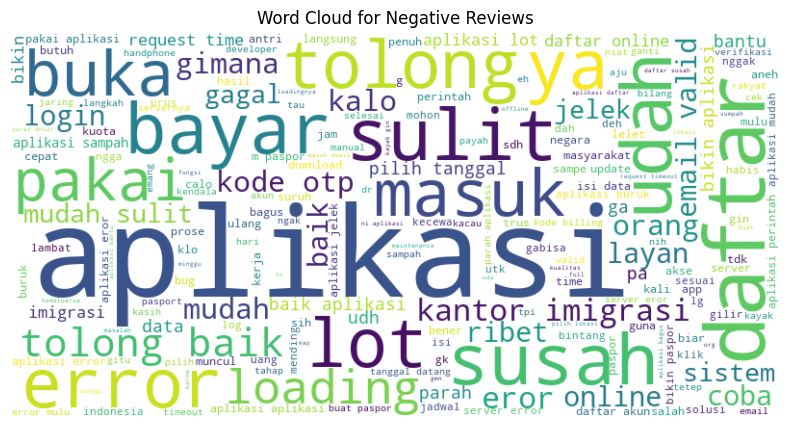

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for negative label records
negative_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


In [ ]:
import joblib

# Assuming your model is named 'svm_model'
joblib.dump(svm_model, 'svm_model.pkl')

# If you also need to save your vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

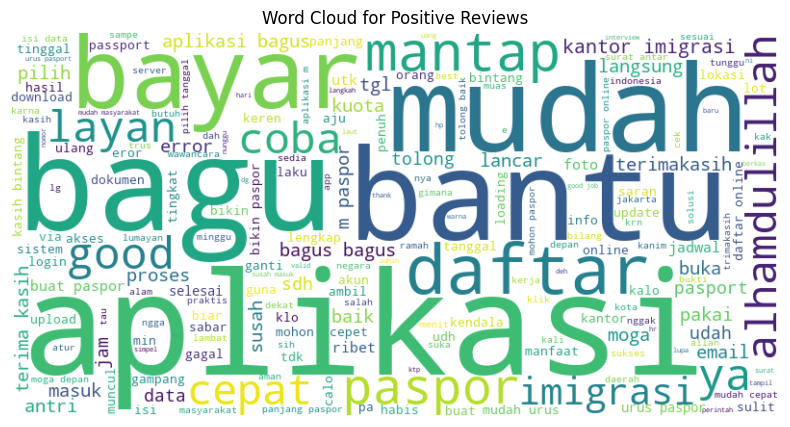

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for positive label records
positive_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()


In [ ]:
# Support Vector Machine (SVM)
svm_predicted = svm_model.predict(X_test_tfidf)
svm_report = classification_report(y_test, svm_predicted, zero_division=0)

print("SVM Classification Report:")
print(svm_report)

SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.98      0.95      2094
    Positive       0.81      0.53      0.64       332

    accuracy                           0.92      2426
   macro avg       0.87      0.76      0.80      2426
weighted avg       0.91      0.92      0.91      2426

